In [1]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 2.5 MB/s 
     |████████████████████████████████| 37.1 MB 44 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


from pathlib import Path


SEED = 13
random.seed(SEED)
np.random.seed(SEED)

path_tr = '/content/drive/MyDrive/TZ/myte/input/xtrain.npy'
path_mask = '/content/drive/MyDrive/TZ/myte/input/ytrain.npy'
path_test = '/content/drive/MyDrive/TZ/myte/input/xtest.npy'


In [2]:
tr = np.load(path_tr)
tr_mask = np.load(path_mask)
tr.shape, tr_mask.shape

((15137, 256, 256, 1), (15137, 8))

In [3]:
def find_bbox(data: list) -> tuple:
    # from skimage.measure import label, regionprops    
    """
    # https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
    Label connected regions of this mask using skimage.measure.label
    Measure morphological properties of these connected regions and keep
    the bounding box (skimage.measure.regionprops). For each connected region
    a bounding box of the form (min_row, min_col, max_row, max_col) is returned.
    
    data: list, mask
    return: tuple, x1, y1, x2, y2
    """
    
    l0 = label(data)
    pr = regionprops(l0)
    return pr[0].bbox[1], pr[0].bbox[0], pr[0].bbox[4], pr[0].bbox[3]


def show_board(image: list, points: list, idx: int) -> None:
    points = points * 255
    make_pair = list([int(i), int(j)] for i, j in zip(points[0::2], points[1::2]))
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255)
    fb = find_bbox(mask)
    img = np.squeeze(image)
    mask = np.squeeze(mask)
    masked_image = cv2.bitwise_and(img, mask)
    
    fig, axes = plt.subplots(1,4,figsize=(14,8), sharex=True, sharey=True)

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Image')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')
    axes[2].imshow(masked_image, cmap='gray')
    axes[2].set_title('Mask Image')
    axes[2].axis('off')
    im = img.copy()
    cv2.rectangle(
        im, 
        (int(fb[0]), int(fb[1])),
        (int(fb[2]), int(fb[3])),
        (255,0,0),
        3
    )    
    axes[3].imshow(im, cmap='gray')
    axes[3].set_title('Bbox')
    axes[3].axis('off')
    plt.subplots_adjust(wspace=0)
    plt.suptitle(f'Index image: {idx}', y = .75)
    plt.show()

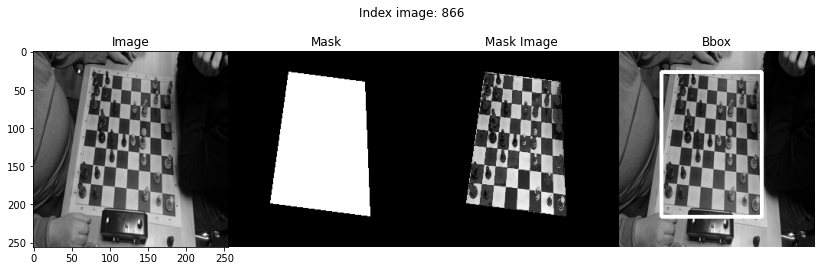

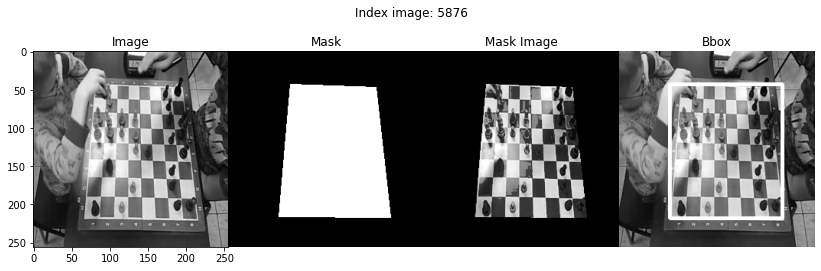

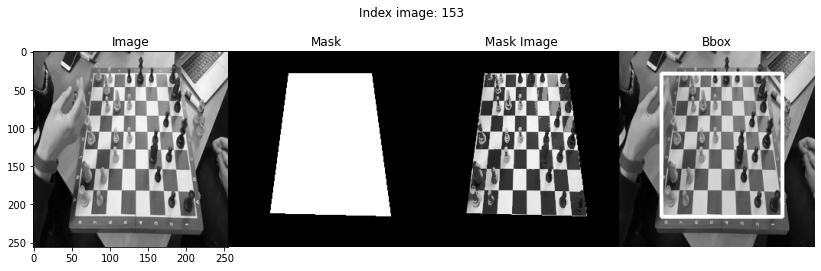

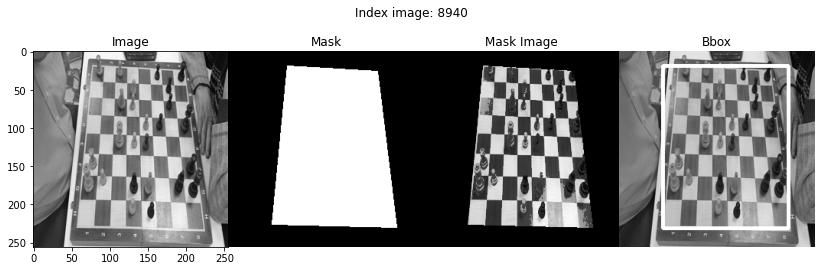

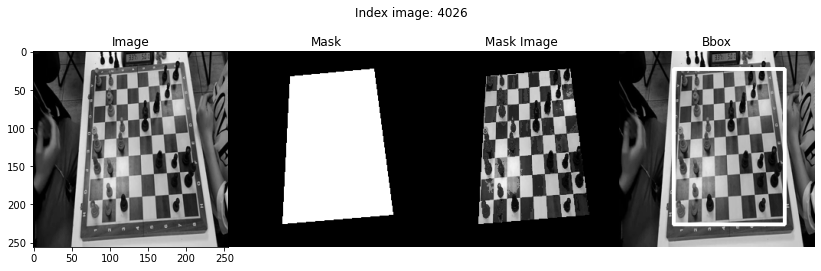

In [ ]:
for _ in range(5):
    idx = np.random.choice(tr.shape[0])
    show_board(tr[idx], tr_mask[idx], idx)

In [3]:
import torch
import torchvision
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import albumentations as A

In [53]:
def collate_fn(batch):
    return tuple(zip(*batch))


class Chess_Dataset(Dataset):

    def __init__(self, data, point, transforms = None):
        self.data = data
        self.point = point
        self.transforms = transforms

    def __len__(self):
        return len(self.data)     

    def __getitem__(self, idx):
        boxes = []
        target = {}    
        img = self.data[idx]  
        pt = self.point[idx]
        #make mask
        pt = pt * 255
        make_pair = list([int(i), int(j)] for i, j in zip(pt[0::2], pt[1::2]))
        # mask = np.zeros_like(img)
        mask = np.zeros((256, 256), dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255) 
        # find bbox by mask
        pos = np.where(np.array(mask) > 0)           
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin / 256.0 , ymin / 256.0 , xmax / 256.0 , ymax / 256.0 ]) 
        
        if self.transforms:
            sample = {
                'image': img,
                'masks': [mask],
                'bboxes':boxes,
                'labels': [str(1)]
                }
            sample = self.transforms(**sample)
            img = sample['image']
            mask = sample['masks']
            bboxes = sample['bboxes']     

        img = img / 255.0     
        img = img.transpose(2, 0, 1).astype(np.float32)
        boxes = torch.as_tensor(bboxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target['masks'] = torch.as_tensor(mask, dtype=torch.uint8)
        target['boxes'] = boxes
        target['area'] = area   
        target['image_id'] = torch.tensor([idx], dtype = torch.float16)  
        target['labels'] = torch.ones(1, dtype = torch.long)      
        target['iscrowd'] = torch.zeros(1, dtype=torch.long) 
           
        return torch.tensor(img, dtype = torch.float32), target

In [48]:
def tr_transform():
  return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    # A.RandomBrightnessContrast(brightness_limit=0.8,
                    #                            contrast_limit=0.8,
                    #                            p=0.5),
                    ],
                   bbox_params=A.BboxParams(format='albumentations', 
                                            label_fields=['labels']
                                            ),
                   )


dataset = Chess_Dataset(tr, tr_mask, tr_transform())
data_loader_mask = DataLoader(dataset,
                              batch_size=2,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=collate_fn)

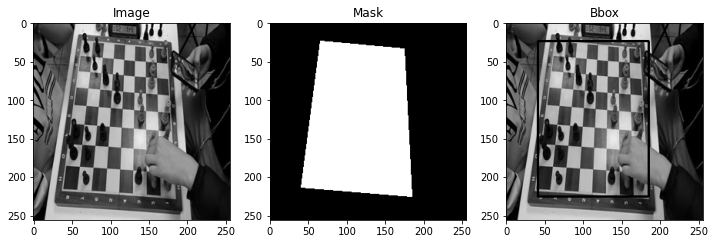

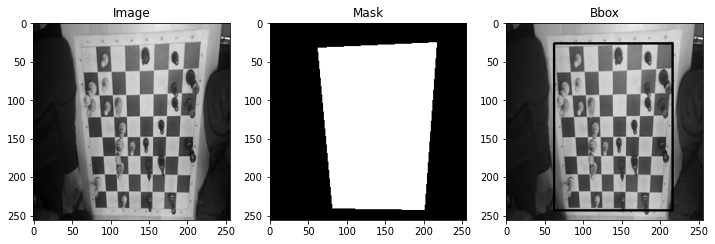

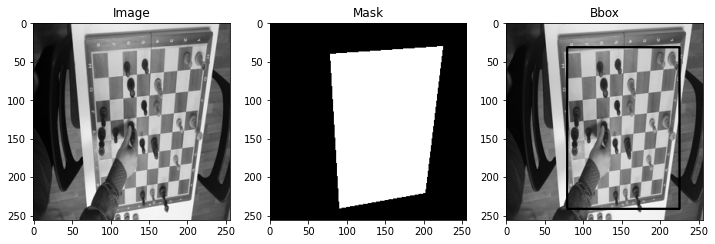

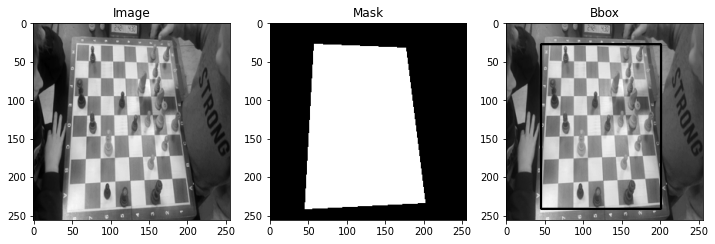

In [60]:
for _ in range(2):
    image, target = next(iter(data_loader_mask))
    for i, d in enumerate(target):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 5))
        box = d['boxes'].cpu().numpy() * 256
        mask = d['masks'].cpu().numpy()
        im = image[i].cpu().numpy()   
        im  = np.transpose((im * 255).astype(np.uint8), (1,2,0))
        im = np.squeeze(im)
        mask = np.squeeze(mask)

        im_ori = im.copy()
        for bx in box:
            cv2.rectangle(
            im,
            (int(bx[0]), int(bx[1])),
            (int(bx[2]), int(bx[3])),
            (0,0,0), 2
            )
        ax1.imshow(im_ori, cmap='gray')
        ax1.set_title('Image')
        ax2.imshow(mask, cmap='gray')
        ax2.set_title('Mask')
        ax3.imshow(im, cmap='gray')
        ax3.set_title('Bbox')